# call a extractor

In [1]:
from data import store,raw_data

In [16]:
from competition.extractors import Raw,Combine,SelectByClickTime
from run_1_extract_features import extract_features

extractFile = 'raw.db'
extractor = Combine([Raw()])

extract_features(extractor,extractFile,raw_data)

extracting features...
saving features into ./_extracted/raw.db
extracting features...done


In [2]:
from competition.extractors import Raw,Combine,SelectByClickTime
from run_1_extract_features import extract_features

extractFile = 'train.db'
extractor = Combine([Raw(),SelectByClickTime([170000,290000])])

extract_features(extractor,extractFile,raw_data)

extracting features...
saving features into ./_extracted/train.db
extracting features...done


In [3]:
from competition.extractors import Raw,Combine,SelectByClickTime
from run_1_extract_features import extract_features

extractFile = 'val.db'
extractor = Combine([Raw(),SelectByClickTime([300000,320000])])

extract_features(extractor,extractFile,raw_data)

extracting features...
saving features into ./_extracted/val.db
extracting features...done


# design a extractor 

In [4]:
from data import store,raw_data
from extracted import loadFile

fname = 'train.db'
ext = loadFile(fname)
trX = ext['trX']
trY = ext['trY']

fname = 'val.db'
ext = loadFile(fname)
valX = ext['trX']
valY = ext['trY']

In [5]:
import numpy as np
import pandas as pd
def CvrStatisticsByKey(train_label,X,key):
    dfCvr = train_label.groupby(key).apply(lambda df: np.mean(df["label"])).reset_index()
    dfCvr.columns=[key,key+'Cvr']
    newX = pd.merge(X,dfCvr,on=key,how='left')
    return newX

def split_time(tm):
    day=(tm//10000)%7
    hour = (tm%10000)//100
    minute = (tm%100)
    return (day,minute,hour)

def convertTime(df):
    timeInfo = df.apply(lambda row: split_time(row['clickTime']), axis=1)
    df['clickDay'],df['clickHour'],df['clickMin']=zip(*timeInfo)
    return df

dfTrain = convertTime(trX.copy())
dfTrain['label']=trY.copy()

def _extract(X,y,raw_data):
    newX = convertTime(X)
    newX = X
    newX = CvrStatisticsByKey(dfTrain,newX,'appID')
    newX = CvrStatisticsByKey(dfTrain,newX,'positionID')
    newX = CvrStatisticsByKey(dfTrain,newX,'connectionType')
    newX = CvrStatisticsByKey(dfTrain,newX,'camgaignID')
    newX = CvrStatisticsByKey(dfTrain,newX,'count_act')
    newX = CvrStatisticsByKey(dfTrain,newX,'clickDay')
    del newX['clickTime']
    del newX['appID']
    return newX,y,raw_data

In [6]:
trX, trY, _ = _extract(trX, trY, raw_data)
valX, valY, _ = _extract(valX, valY, raw_data)

In [7]:
trX.head()

,appPlatform,hometown,count_inst,haveBaby,count_act,adID,education,telecomsOperator,userID,sitesetID,...,positionType,clickDay,clickHour,clickMin,appIDCvr,positionIDCvr,connectionTypeCvr,camgaignIDCvr,count_actCvr,clickDayCvr
0,1,0,44,1,NaN,1321,1,1,2798058,0,...,3,3,0,-0,0.000736,0.013052,0.030003,0.000000,NaN,0.025606
1,2,0,NaN,0,NaN,1535,1,2,463234,0,...,1,3,0,-0,0.002641,0.000909,0.030003,0.002449,NaN,0.025606
2,1,0,NaN,0,NaN,147,1,1,1857485,0,...,1,3,0,-0,0.020293,0.008420,0.006756,0.016228,NaN,0.025606
3,1,0,69,0,7,411,0,1,2038823,0,...,1,3,0,-0,0.020293,0.016123,0.030003,0.016121,0.035583,0.025606
4,1,1001,NaN,0,1,369,2,1,2015141,0,...,1,3,0,-0,0.034999,0.007508,0.030003,0.047676,0.035289,0.025606


# validation

In [8]:
class OnlyCvr(object):
    def fit(self,X,y):
        return self
    def predict(self,X):
        return X['appCvr'].fillna(0)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from xgboost.sklearn import XGBModel
from sklearn.ensemble import RandomForestClassifier
from competition.models import logloss

import numpy as np
def strip_feats_X(X,idx,dels):
    X=X[idx]
    for k in dels:
        del X[k]
    return X,idx

def split_data_into_4_X(X):
    act_null_idx = np.isnan(X['count_act'])
    inst_null_idx = np.isnan(X['count_inst'])
    # all information complete
    idx1 = ~(act_null_idx | inst_null_idx)
    del1 = []    
    # lack of all other information
    idx2 = (act_null_idx&inst_null_idx)
    del2 = ['count_inst','appCate1_inst','count_act','appCate1_act']    
    # only lack of act
    idx3 = act_null_idx&(~idx2)
    del3 = ['count_act','appCate1_act']    
    # only lack of inst
    idx4 = inst_null_idx&(~idx2)
    del4 = ['count_inst','appCate1_inst']
    return [strip_feats_X(X,idx1,del1),
           strip_feats_X(X,idx2,del2),
           strip_feats_X(X,idx3,del3),
           strip_feats_X(X,idx4,del4),]
    
def split_data_into_4(X,y):
    return [(_x,y[_idx]) for _x,_idx in split_data_into_4_X(X)]

class FourEsts(object):
    def __init__(self):
        self.ests = [XGBModel(n_estimators=50,objective='reg:logistic'),
                  XGBModel(n_estimators=50,objective='reg:logistic'),
                  XGBModel(n_estimators=50,objective='reg:logistic'),
                  XGBModel(n_estimators=50,objective='reg:logistic')]
    def fit(self,X,y):
        for i,(_x,_y) in enumerate(split_data_into_4(X,y)):
            self.ests[i].fit(_x,_y)
        return self
    
    def predict(self,X):
        y = np.zeros([X.shape[0]])
        for i,(_x,_idx) in enumerate(split_data_into_4_X(X)):
            _y = self.ests[i].predict(_x)
            y[_idx] = _y
        return y
    def loss(self,X,y):
        y = y.as_matrix()
        res = []
        for i,(_x,_idx) in enumerate(split_data_into_4_X(X)):
            _y = self.ests[i].predict(_x)
            res.append(logloss(y[_idx],_y))
        return res

In [10]:
estimator = FourEsts()
estimator = XGBModel(n_estimators=150,objective='reg:logistic')

In [11]:
estimator.fit(trX,trY)

XGBModel(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
     learning_rate=0.1, max_delta_step=0, max_depth=3, min_child_weight=1,
     missing=None, n_estimators=150, nthread=-1, objective='reg:logistic',
     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
     subsample=1)

In [12]:
#estimator.loss(valX,valY)

AttributeError: 'XGBModel' object has no attribute 'loss'

In [13]:
from competition.models import official_score
print -official_score(estimator,trX,trY)
print -official_score(estimator,valX,valY)

0.101537492526
0.0913294225522


## record1(origin)       
- 0.104726901926  
- 0.124660252014

## record2(origin+cvr)  
- 0.103728718243  
- 0.127432079715

## record2(use cvr)  
- 0.109738338197  
- 0.119089350834

## record3(rf)
- 0.23114836522
- 1.15164827966

## record4(split-time+xgb+cvr)
- 0.103214516872
- 0.117468540242

## record5(split-time+xgb+appcvr+poscvr)
- 0.100127016268
- 0.120103391753

## record6(above+appcate1_actcvr+est=50+logistic)
- 0.101986737032
- 0.116966472891

## record7(above+connectionTypeCVR+est=50+logistic)
- 0.101914773732
- 0.116814070908

## record7(above+connectionTypeCVR+camgaignIDCvr+est=50+logistic)
- 0.100868704737
- 0.115180648311

## record8(all above + dayCvr)
- 0.100868704737
- 0.115180648311

Populating the interactive namespace from numpy and matplotlib


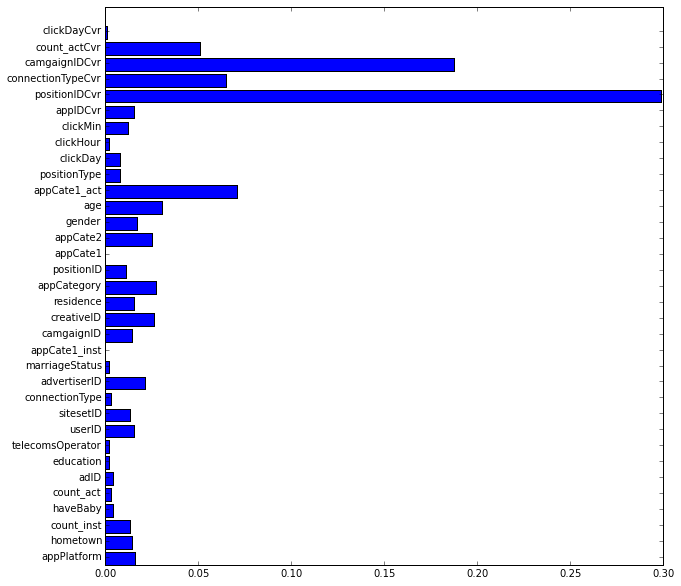

In [15]:
%pylab inline
figure(figsize=(10,10))

fimp = estimator.feature_importances_
fnames=trX.columns

idx = np.arange(len(fimp))
barh(idx, fimp)
yticks(idx+0.5,fnames)
show()

In [14]:
%pylab inline
for i in range(4):
    figure(figsize=(10,10))

    fimp = estimator.ests[i].feature_importances_
    fnames=trX.columns

    idx = np.arange(len(fimp))
    barh(idx, fimp)
    yticks(idx+0.5,fnames)
    show()

Populating the interactive namespace from numpy and matplotlib


AttributeError: 'XGBModel' object has no attribute 'ests'

# save and run the new extractor
- save extractor into file
- modify and save `configCustom.py`
- run `run_1_extract_features.py`

In [ ]:
%%writefile competition/extractors/StatsFeatures.py
from competition.extractors.Base import BaseExtractor
import pandas as pd
import numpy as np
import os

def CvrStatisticsByKey(train_label,X,key):
    dfCvr = train_label.groupby(key).apply(lambda df: np.mean(df["label"])).reset_index()
    dfCvr.columns=[key,key+'Cvr']
    newX = pd.merge(X,dfCvr,on=key,how='left')
    return newX

def split_time(tm):
    day=(tm//10000)%7
    hour = (tm%10000)//100
    minute = (tm%100)
    return (day,minute,hour)

def convertTime(df):
    timeInfo = df.apply(lambda row: split_time(row['clickTime']), axis=1)
    df['clickDay'],df['clickHour'],df['clickMin']=zip(*timeInfo)
    return df

def stats_extract(X,y,raw_data,dfTrain):
    newX = convertTime(X)
    newX = X
    newX = CvrStatisticsByKey(dfTrain,newX,'appID')
    newX = CvrStatisticsByKey(dfTrain,newX,'positionID')
    newX = CvrStatisticsByKey(dfTrain,newX,'connectionType')
    newX = CvrStatisticsByKey(dfTrain,newX,'camgaignID')
    newX = CvrStatisticsByKey(dfTrain,newX,'count_act')
    newX = CvrStatisticsByKey(dfTrain,newX,'clickDay')
    del newX['clickTime']
    del newX['appID']
    return newX,y,raw_data

class StatsFeatures(BaseExtractor):
    def __init__(self,X,y):
        self.dfTrain = convertTime(X.copy())
        self.dfTrain['label']=y.copy()

    def get_train(self,X,y,raw_data):
        return self._extract(X,y,raw_data)

    def get_test(self,X,y,raw_data):
        return X,y,raw_data

    def _extract(self,X,y,raw_data):
        return stats_extract(newX,y,raw_data,self.dfTrain)

In [ ]:
# only run once
!echo "from StatsFeatures import StatsFeatures" >> competition/extractors/__init__.py
!cat competition/extractors/__init__.py

In [ ]:
%%writefile config1_rc.py
# -*- coding:utf-8 -*-
from competition.extractors import *

extractDir = './_extracted/'
extractFile = 'raw_stats.db'

# extractor
import pandas as pd
import os
inFile = 'raw.db'
ext = pd.HDFStore(os.path.join(extractDir,inFile))
trX = ext['trX']
trY = ext['trY']
teX = ext['teX']
extractor = Combine([Wrapper(trX,trY,teX),StatsFeatures(trX,trY)])

In [ ]:
%run run_1_extract_features.py

In [ ]:
from extracted import loadFile

In [ ]:
loadFile()